# Práctica 3 - Regresión Logística

**Curso:** Statistical Learning

**Catedrático:** Ing. Luis Leal

**Estudiante:** Dany Rafael Díaz Lux (21000864)

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 15s 3us/step


## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

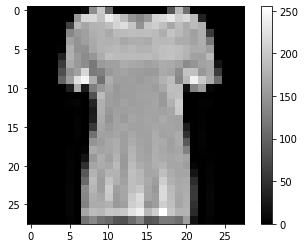

In [4]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [10]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

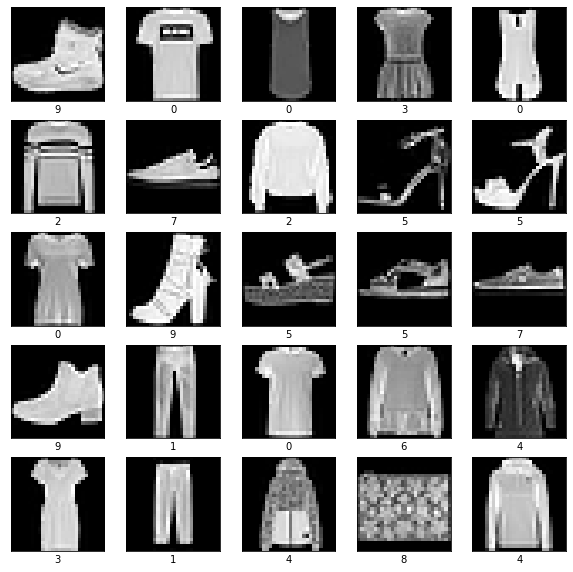

In [6]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

In [36]:
# Filtrar valores de etiquetas escogidas: 1 (Trouser), 3 (Dress), 5 (Sandal)
filteredTrainImages = train_images[(train_labels == 1) | (train_labels == 3) | (train_labels == 5)]
filteredTrainLabels = train_labels[(train_labels == 1) | (train_labels == 3) | (train_labels == 5)]
filteredTestImages = test_images[(test_labels == 1) | (test_labels == 3) | (test_labels == 5)]
filteredTestLabels = test_labels[(test_labels == 1) | (test_labels == 3) | (test_labels == 5)]

In [39]:
print(filteredTrainImages.shape)
print(filteredTrainLabels.shape)
print(filteredTestImages.shape)
print(filteredTestLabels.shape)

(18000, 28, 28)
(18000,)
(3000, 28, 28)
(3000,)


### Modificar forma de imágenes
Convertir imágenes de cubos de pixeles (18000, 28, 28) a  matrices de pixeles (18000, 784)

In [42]:
xFilteredTrainImages = filteredTrainImages.reshape(filteredTrainImages.shape[0], filteredTrainImages.shape[1] * filteredTrainImages.shape[2])
xFilteredTestImages = filteredTestImages.reshape(filteredTestImages.shape[0], filteredTestImages.shape[1] * filteredTestImages.shape[2])

In [204]:
print(xFilteredTrainImages.shape)
print(xFilteredTestImages.shape)

(18000, 784)
(3000, 784)


### Funciones para "escalar" información

In [217]:
# Normalizará la variable: x_norm = (x - media(x))/(max(x)-(min(x)))
def normalizar(x):
    media = np.mean(x)
    maximum = np.amax(x)
    minimum = np.amin(x)
    
    return (x - media) / (maximum - minimum)

# Estandarizará la variable: x_stand = (x - media(x))/(desviacion(x)))
def estandarizar(x):
    media = np.mean(x)
    desviacion = np.std(x)
    
    return (x - media) / (desviacion)

### Crear datos "X" normalizados y estandarizados

In [225]:
# Datos normalizados
xNormalizedTrainImages = normalizar(xFilteredTrainImages)
xNormalizedTestImages = normalizar(xFilteredTestImages)
# Datos estandarizados
xStandarizedTrainImages = estandarizar(xFilteredTrainImages)
xStandarizedTestImages = estandarizar(xFilteredTestImages)

### Regresión Logística con Softmax

Crear una clase para modelo logístico con Softmax:

In [241]:
# Definir modelo y funciones para aplicación de modelo de regresión logística con SoftMax (para salida multi clase)
class ModeloLogisticoSoftmax:
    def __init__(self, numCaracteristicas, numEtiquetas):
        self.parametros = tf.get_variable(name="Parametros", dtype=tf.float32, shape=[numCaracteristicas, numEtiquetas], \
                                          initializer=tf.zeros_initializer(), use_resource=True)
        
    def calcularLogits(self, matrizX):
        return tf.matmul(matrizX, self.parametros)
    
    def calcularSoftmax(self, logits):
        return tf.nn.softmax(logits)
    
    def calcularPorcentajeCorrecto(self, logits, etiquetasY):
        softmaxY = self.calcularSoftmax(logits)
        boolSonIguales = tf.equal(tf.argmax(softmaxY, 1), tf.argmax(etiquetasY, 1))
        intSonIguales = tf.dtypes.cast(boolSonIguales, tf.int32)
        porcentajeCorrecto = tf.divide(tf.reduce_sum(intSonIguales), tf.shape(etiquetasY)[0])
        return porcentajeCorrecto
    
    def actualizar(self, matrizX, etiquetasY, learning_rate):
        with tf.name_scope("Error"):
            logits = self.calcularLogits(matrizX)
            error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(etiquetasY, logits))
            
        with tf.name_scope("Gradiente"):
            gradiente = tf.gradients(error, self.parametros)
        
        with tf.name_scope("Actualizar_Parametros"):
            multGradLr = tf.math.multiply(gradiente[0], learning_rate)
            restarParametros = tf.math.subtract(self.parametros, multGradLr)
            actualizacionParametros = tf.assign(self.parametros, restarParametros)
            
        return actualizacionParametros
    
    def calcularError(self, matrizX, etiquetasY):
        with tf.name_scope("Calcular_error_general"):
            logits = self.calcularLogits(matrizX)
            error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(etiquetasY, logits))
        
        with tf.name_scope("Calcular_porcentaje_correcto"):
            porcentajeAcierto = self.calcularPorcentajeCorrecto(logits, etiquetasY)
        
        return error, porcentajeAcierto
    
    def obtenerTrainSummaries(self, matrizX, etiquetasY):
        error, porcentajeAcierto = self.calcularError(matrizX, etiquetasY)
        
        errorSummary = tf.summary.scalar("Train_Error", error)
        aciertoSummary = tf.summary.scalar("Train_Accuracy_Percentage", porcentajeAcierto)
        
        return error, porcentajeAcierto, errorSummary, aciertoSummary

    def obtenerTestSummaries(self, matrizX, etiquetasY):
        error, porcentajeAcierto = self.calcularError(matrizX, etiquetasY)
        
        errorSummary = tf.summary.scalar("Test_Error", error)
        aciertoSummary = tf.summary.scalar("Test_Accuracy_Percentage", porcentajeAcierto)
        
        return error, porcentajeAcierto, errorSummary, aciertoSummary


### Definir entrenamiento con Gradient Descent

In [248]:
def agregarColumnaUnos(x):
    if len(x.shape) < 2:
        x = np.array(x).reshape(x.shape[0], -1)
    
    return np.append(x, np.ones(x.shape[0]).reshape(-1,1), 1)

# Función que convertirá etiquetas, aplicando el algoritmo de one hot encoding, a una matriz de ceros y unos
# Suposiciones, las etiquetas serán números enteros desde 0 hasta un número positivo
def generarOneHotEncoding(etiquetas):
    etiquetasUnicas = np.unique(etiquetas)
    oneHot = np.zeros(shape=[etiquetas.shape[0], etiquetasUnicas.shape[0]])
    filas = np.arange(etiquetas.shape[0])
    columnas = []
    for etiqueta in etiquetas:
        columnas.append(np.where(etiquetasUnicas == etiqueta)[0][0])
        
    oneHot[filas, columnas] = 1
    return oneHot

def trainingPorMiniBatchGradientDescent(trainX, trainY, testX, testY, epochs, learningRate, batchSize = -1):
    # Agregar columna de sesgo (con unos)
    trainX = agregarColumnaUnos(trainX)
    # Crear matriz con el algoritmo de one hot encoding
    yOneHot = generarOneHotEncoding(trainY)
    # Cantidad de datos, características y etiquetas enviadas
    cantidadDatos = trainX.shape[0]
    numCaracteristicas = trainX.shape[1]
    numEtiquetas = yOneHot.shape[1]
    # Dar formato adecuado a información de validación
    testX = agregarColumnaUnos(testX)
    # Crear matriz con el algoritmo de one hot encoding
    yTestOneHot = generarOneHotEncoding(testY)
    
    # Si el batch size es mayor que la cantidad de datos, simplemente se usa la cantidad de datos
    if batchSize > cantidadDatos | batchSize < 0:
        batchSize = cantidadDatos
    # Se determina número de iteraciones
    totalIteraciones = cantidadDatos // batchSize
    
    # Grafo de TensorFlow a utilizar
    g = tf.Graph()
    with g.as_default():
        modelo = ModeloLogisticoSoftmax(numCaracteristicas, numEtiquetas)
        matrizX = tf.placeholder(tf.float32,[None, None],"matrizX")
        etiquetasY = tf.placeholder(tf.float32,[None, None],"etiquetasY")
        #calcularPrediccion = modelo(matrizX) #Esto creará la definición para la operación y = mx + b
        actualizarParametros = modelo.actualizar(matrizX, etiquetasY, learningRate) # Definición para actualizar parámetros
        ObtenerTrainSummaries = modelo.obtenerTrainSummaries(matrizX, etiquetasY)
        ObtenerTestSummaries = modelo.obtenerTestSummaries(matrizX, etiquetasY)
        directorioModelo = './summaries/' + dt.datetime.now().strftime("%Y%m%d-%H%M%S") +  \
             '_RegresionLogisticaSoftmaxMiniBatchGradientDescent' \
            + '_epochs=' + str(epochs) + '_lr=' + str(learningRate) + '_batchSize=' + str(batchSize)

        with tf.train.MonitoredSession() as session:
            writer = tf.summary.FileWriter(directorioModelo, g)
            for epoch in range(epochs):
                for batch in range(totalIteraciones):
                    inicioBatch = batch * batchSize
                    finBatch = inicioBatch + batchSize - 1
                    if (cantidadDatos - finBatch) < batchSize:
                        finBatch = cantidadDatos
                    miniBatchX =  np.array(trainX[inicioBatch:finBatch,:])
                    miniBatchY = np.array(yOneHot[inicioBatch:finBatch,:])
                    # Realizar la actualización de parámetros por mini batch
                    feed_dict = {matrizX: miniBatchX, etiquetasY: miniBatchY}
                    # Si no es la última iteración sólo correr actualización de parámetros
                    if batch != totalIteraciones - 1:
                        session.run(actualizarParametros,feed_dict=feed_dict)
                    # De lo contrario obtener error final de epoch y parámetros
                    else:
                        parametros = session.run(actualizarParametros,feed_dict=feed_dict)
                
                # Calcular error general de modelo en data set de entrenamiento
                feed_dict = {matrizX: trainX, etiquetasY: yOneHot}
                trainError, trainAcierto, trainErrorSummary, trainAciertoSummary = session.run(ObtenerTrainSummaries, feed_dict=feed_dict)
                # Calcular error general de modelo en data set de test
                feed_dict = {matrizX: testX, etiquetasY: yTestOneHot}
                testError, testAcierto, testErrorSummary, testAciertoSummary = session.run(ObtenerTestSummaries, feed_dict=feed_dict)
                
                # Añadir error a summary de tensorboard
                writer.add_summary(trainErrorSummary, epoch)
                writer.add_summary(trainAciertoSummary, epoch)
                writer.add_summary(testErrorSummary, epoch)
                writer.add_summary(testAciertoSummary, epoch)
            writer.close()
    
            print('Modelo MiniBatch. Epochs: ', epochs, ', learning rate: ', learningRate, ', Batch size: ', batchSize, \
                  ', Error entrenamiento: ', trainError, ', %Entrenamiento: ', trainAcierto, \
                 ', Error validación: ', trainError, ', %Validación: ', testAcierto)
    
    return parametros

### Grafo de Modelo con Regresión Logística Softmax

<img src='Grafo_ModeloRegresionLogisticaSoftmax.png'>

### Búsqueda de modelos

1. Primero se evaluarán modelos con distintos hiperparámetros. Aquellos hiperparámetros que muestren el error más pequeño y acierto más alto tanto para la información de entrenamiento como para la información de validación será el modelo que se escogerá.
2. Se probará el modelo escogido con la información de entrada normalizada y estandarizada y se observará si alguna métrica mejora.

In [243]:
# Variaciones de valores para learning rate
learning_rates = [0.00001, 0.001, 0.1]
epochs = [500]
bSizes = [64, 256, 1024]

for lr in learning_rates:
    for ep in epochs:
        for bSize in bSizes:
            trainingPorMiniBatchGradientDescent(xFilteredTrainImages, filteredTrainLabels, xFilteredTestImages, \
                                                filteredTestLabels, ep, lr, bSize)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  500 , learning rate:  1e-05 , Batch size:  64 , Error entrenamiento:  0.030587077 , %Entrenamiento:  0.9909444444444444 , Error validación:  0.030587077 , %Validación:  0.976
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  500 , learning rate:  1e-05 , Batch size:  256 , Error entrenamiento:  0.028771935 , %Entrenamiento:  0.9911666666666666 , Error validación:  0.028771935 , %Validación:  0.9786666666666667
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  500 , learning rate:  1e-05 , Batch size:  1024 , Error entrenamiento:  0.031029277 , %Entrenamiento:  0.9902777777777778 , Error validación:  0.031029277 , %Validación:  0.9786666666666667
INFO:

### Gráficas y comentarios

De los datos anteriores y las gráficas mostradas abajo, se puede ver que:
* A pesar que el error disminuye mientras más pequeño es el learning rate; los porcentajes de acierto son muy parecidos para todos los modelos. 
* Se decidirá continuar con learning rates pequeños, pues señalan una tendencia más predecible.

<img src='Graficas_train_error.png'>
<img src='Graficas_test_error.png'>

### Pruebas con learning rate reducido y menor número de epochs

In [244]:
# Variaciones de valores para learning rate
learning_rates = [0.00001, 0.000001]
epochs = [250]
bSizes = [128, 256, 512]

for lr in learning_rates:
    for ep in epochs:
        for bSize in bSizes:
            trainingPorMiniBatchGradientDescent(xFilteredTrainImages, filteredTrainLabels, xFilteredTestImages, \
                                                filteredTestLabels, ep, lr, bSize)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  250 , learning rate:  1e-05 , Batch size:  128 , Error entrenamiento:  0.030182112 , %Entrenamiento:  0.9905555555555555 , Error validación:  0.030182112 , %Validación:  0.9783333333333334
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  250 , learning rate:  1e-05 , Batch size:  256 , Error entrenamiento:  0.030557299 , %Entrenamiento:  0.9908333333333333 , Error validación:  0.030557299 , %Validación:  0.979
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  250 , learning rate:  1e-05 , Batch size:  512 , Error entrenamiento:  0.032457914 , %Entrenamiento:  0.9902777777777778 , Error validación:  0.032457914 , %Validación:  0.981
INFO:tensorflow:Gr

### Modelo a escoger

Basado en la información anterior y las gráficas de abajo, se decidirá escoger el modelo con hiper parámetros: learning rate = 1e-06, epochs = 250, batch size = 256; porque **Muestra un buen balance entre el error y porcentaje de acierto entre la información de entrenamiento e información de validación.**

<img src='Graficas_train_error_2.png'>
<img src='Graficas_train_accuracy_2.png'>
<img src='Graficas_test_error_2.png'>
<img src='Graficas_test_accuracy_2.png'>

### Probar modelo con información normalizada y estandarizada

Se probará el modelo escogido con información normalizada y estandarizada para observar si las métricas mejoran:

In [245]:
# Variaciones de valores para learning rate
learning_rates = [0.000001]
epochs = [250]
bSizes = [256]

for lr in learning_rates:
    for ep in epochs:
        for bSize in bSizes:
            trainingPorMiniBatchGradientDescent(xFilteredTrainImages, filteredTrainLabels, xFilteredTestImages, \
                                                filteredTestLabels, ep, lr, bSize)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  250 , learning rate:  1e-06 , Batch size:  256 , Error entrenamiento:  0.039097246 , %Entrenamiento:  0.9877777777777778 , Error validación:  0.039097246 , %Validación:  0.983


In [246]:
# Variaciones de valores para learning rate
learning_rates = [0.000001]
epochs = [250]
bSizes = [256]

for lr in learning_rates:
    for ep in epochs:
        for bSize in bSizes:
            trainingPorMiniBatchGradientDescent(xNormalizedTrainImages, filteredTrainLabels, xNormalizedTestImages, \
                                                filteredTestLabels, ep, lr, bSize)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  250 , learning rate:  1e-06 , Batch size:  256 , Error entrenamiento:  1.0007554 , %Entrenamiento:  0.9423888888888889 , Error validación:  1.0007554 , %Validación:  0.9363333333333334


In [247]:
# Variaciones de valores para learning rate
learning_rates = [0.000001]
epochs = [250]
bSizes = [256]

for lr in learning_rates:
    for ep in epochs:
        for bSize in bSizes:
            trainingPorMiniBatchGradientDescent(xStandarizedTrainImages, filteredTrainLabels, xStandarizedTestImages, \
                                                filteredTestLabels, ep, lr, bSize)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  250 , learning rate:  1e-06 , Batch size:  256 , Error entrenamiento:  0.6428827 , %Entrenamiento:  0.9529444444444445 , Error validación:  0.6428827 , %Validación:  0.947


### Gráficas y comentarios

En este caso particular, basado en los datos anteriores y la gráficas de abajo, parece que ni la normalización ni la estandarización de datos mejoraron ninguna métrica (de hecho empeoraron) sin embargo se puede notar que la estandarización podría lograr el mismo desempeño que con los datos originales si se aumentará los números de epochs.

<img src='Graficas_train_error_3.png'>
<img src='Graficas_train_accuracy_3.png'>
<img src='Graficas_test_error_3.png'>
<img src='Graficas_test_accuracy_3.png'>